# Kaggle data contest : House Price Prediction

https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr

평가 기준)
- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
- 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행과정이 체계적으로 기술되었는가?
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 private score 기준 11000이하의 점수를 얻었는가?

___
## 1. 데이터셋


In [1]:
import xgboost
import lightgbm
import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


1.4.2
3.3.0
0.5.0
1.0


### (1) 필요 모듈 불러오기

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

### (2) 데이터 불러오기

원래 kaggle의 서버에서 설계되어있는 코드는 다음과 같다
>train_data_path = join('../input', 'train.csv')\
>sub_data_path = join('../input', 'test.csv')

그러나 lms 클라우드의 주피터 노트북으로 진행한 것이기 때문에 파일 경로를 그에 맞게 바꿔 주어야 한다. 코드를 작성하기 전에 이에 대해 자세히 알아보자.

- os.getenv('HOME') : 시스템 환경 변수 중 'HOME'에 해당하는 값을 가져오는 함수이다.대부분의 리눅스(/유닉스) 시스템에서 'HOME'변수는 현재 사용자의 홈 디렉토리 경로를 나타낸다. 이를 이용하여 현재 사용자의 홈 디렉토리 경로를 가져온다. 그 뒤에 데이터가 저장될 경로를 지정해준다.

- os.path.join() 함수를 이용해 데이터 경로와 파일 이름을 합쳐서 전체 경로를 만든다. 

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

### (3) 데이터 살펴보기


In [4]:
print(train.shape)
train.head()

(15035, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
print(test.shape)
test.head()

(6468, 20)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [6]:
train.info()
print('='*60)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  


1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [7]:
train['id'].value_counts()

0        1
10027    1
10015    1
10016    1
10017    1
        ..
5016     1
5017     1
5018     1
5019     1
15034    1
Name: id, Length: 15035, dtype: int64

In [8]:
test['id'].value_counts()

15035    1
19344    1
19354    1
19353    1
19352    1
        ..
17187    1
17186    1
17185    1
17184    1
21502    1
Name: id, Length: 6468, dtype: int64

- test 데이터가 train데이터의 거의 절반이 되는 것으로, 꽤 크다는 것을 알 수 있다.
- 위 데이터들을 확인해보니 id 컬럼은 집들의 고유 번호이기 때문에 데이터를 파악하고 예측하는데에 유용한 정보가 아닌 것으로 보인다. 따라서 id 컬럼은 삭제하고 date 컬럼이 object 컬럼이기 때문에 데이터로 활용하기 위해 int형으로 바꾸어 준다.
- train 데이터는 test 데이터보다 price 컬럼이 하나가 많다. price 는 정답데이터이기 때문에 따로 분리하여 준다.
___
전처리를 진행하기 전에 데이터에 결측치가 있는지 확인해주어야 한다.

### (4) 결측치 확인

**missingno**는 EDA 과정에서 데이터의 결측치를 파악하기 쉽게 시각화해주는 라이브러리이다.결측치 확인을 위해 msno.matrix 함수를 사용하도록 한다.

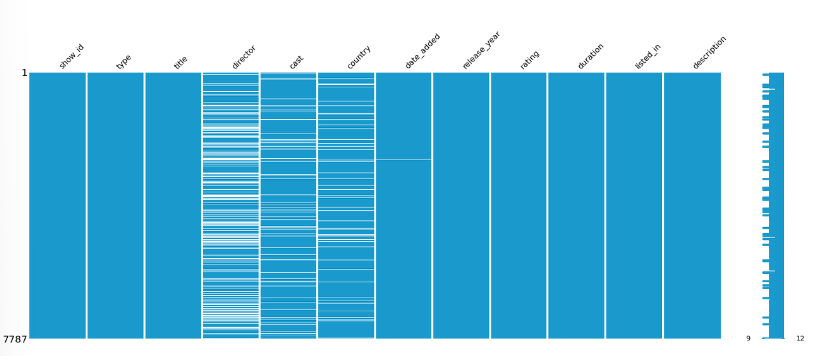
<span style="color : #808080">출처 : https://jaaamj.tistory.com/109</span>

위와 같이 msno.matrix를 사용하면 결측치는 하얀색으로 나타나게 된다.\
그럼 이제 train,test 데이터들의 결측치를 확인해보자

In [9]:
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

<AxesSubplot:>

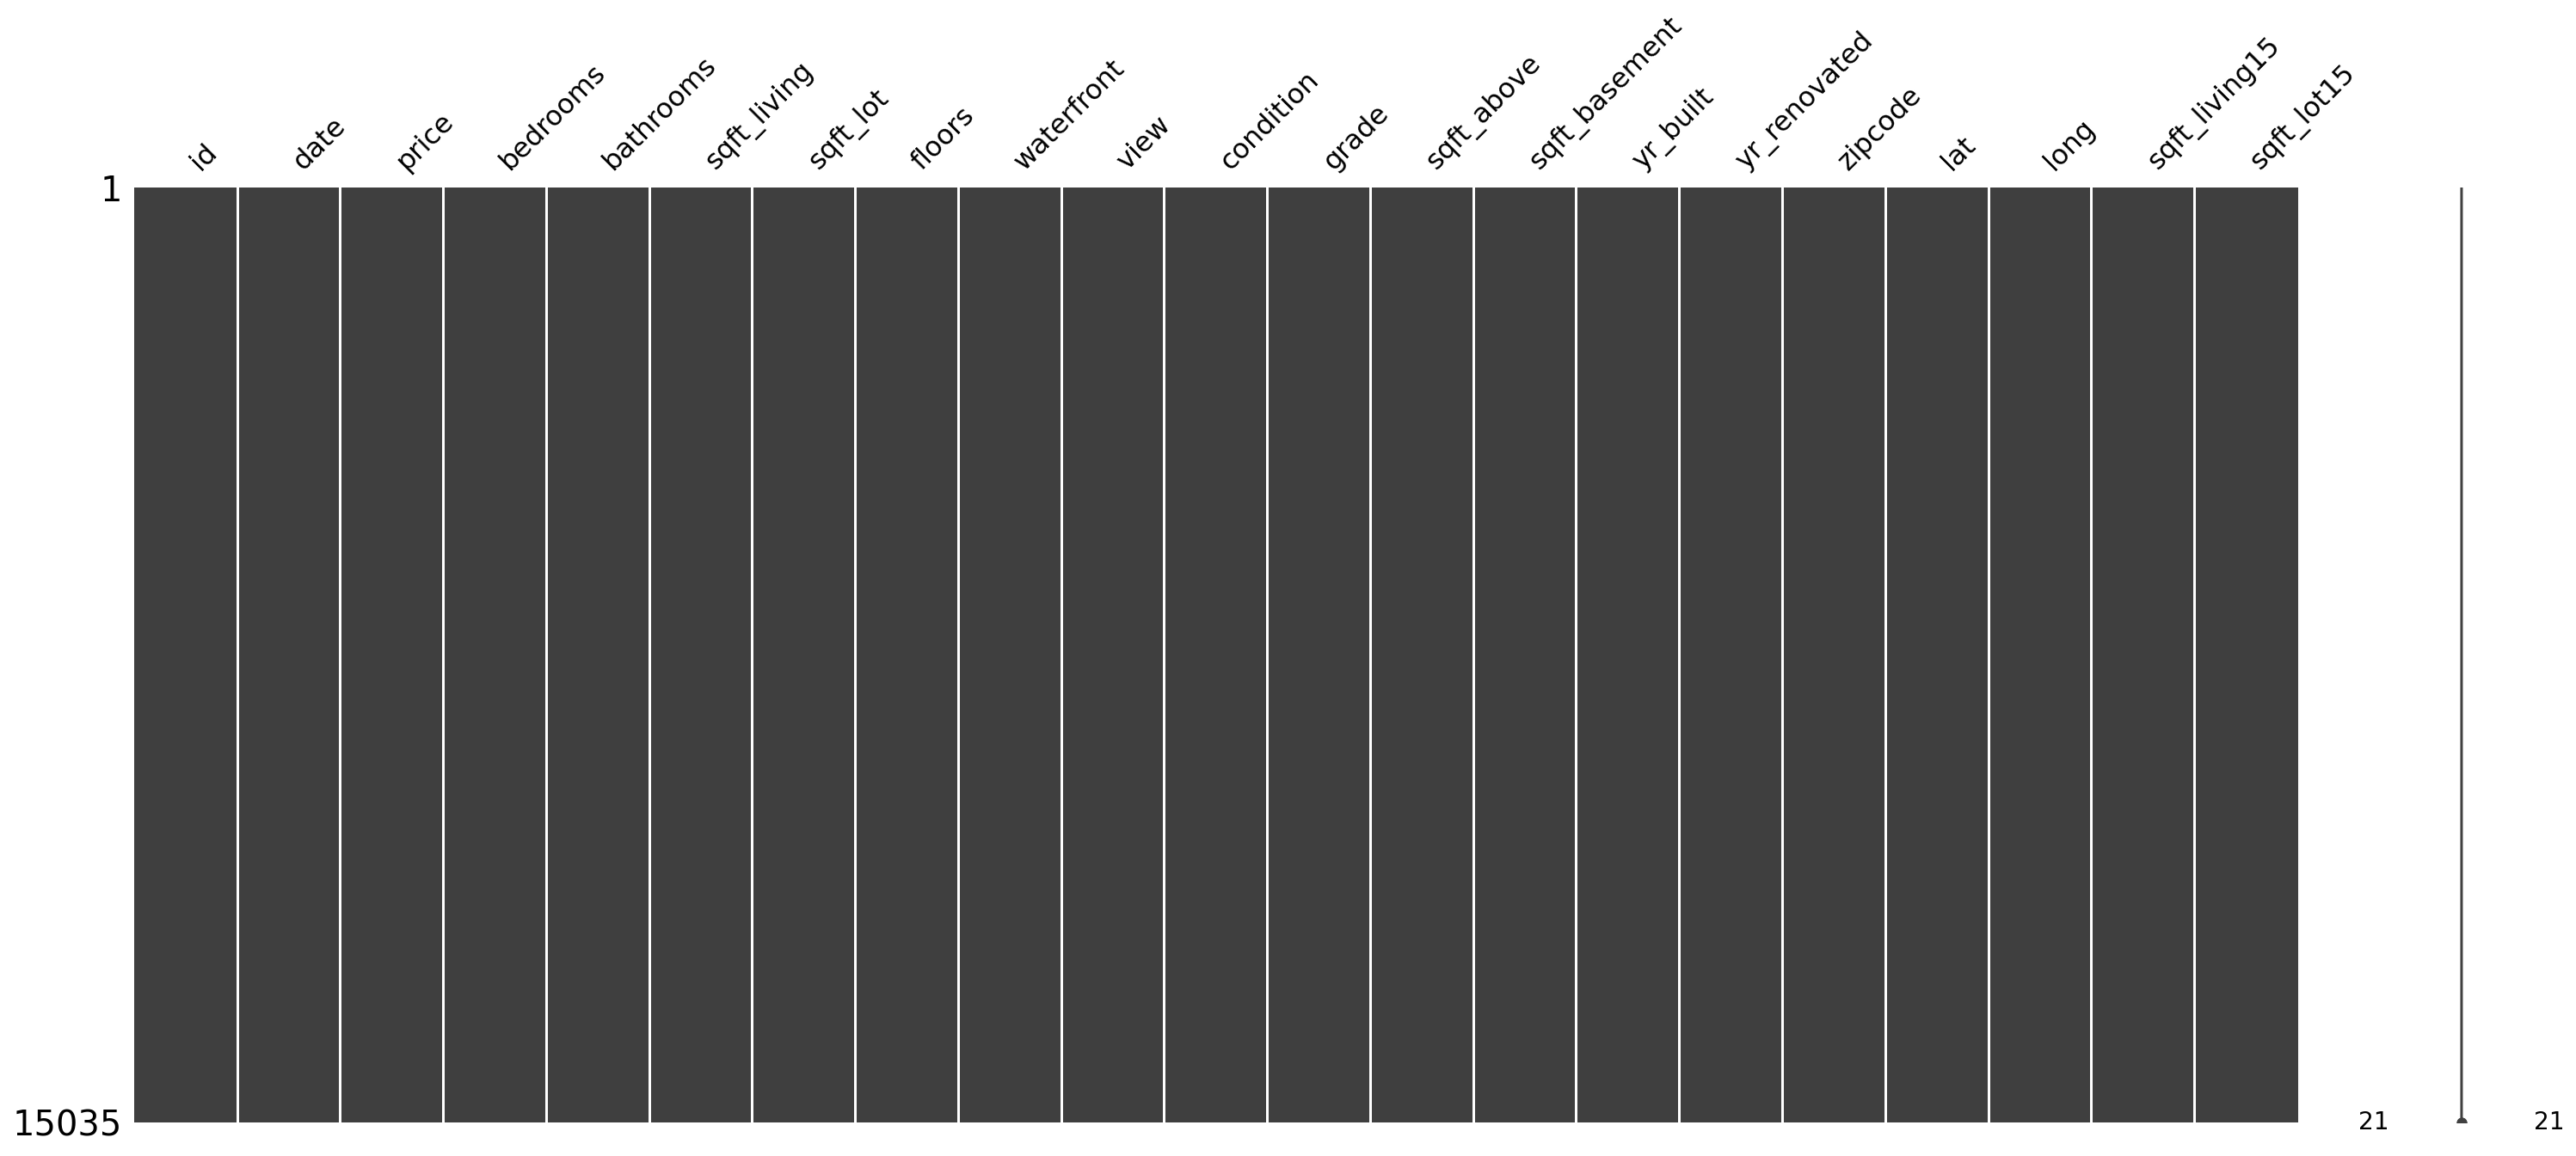

In [10]:
msno.matrix(train)

In [11]:
test.isnull().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

<AxesSubplot:>

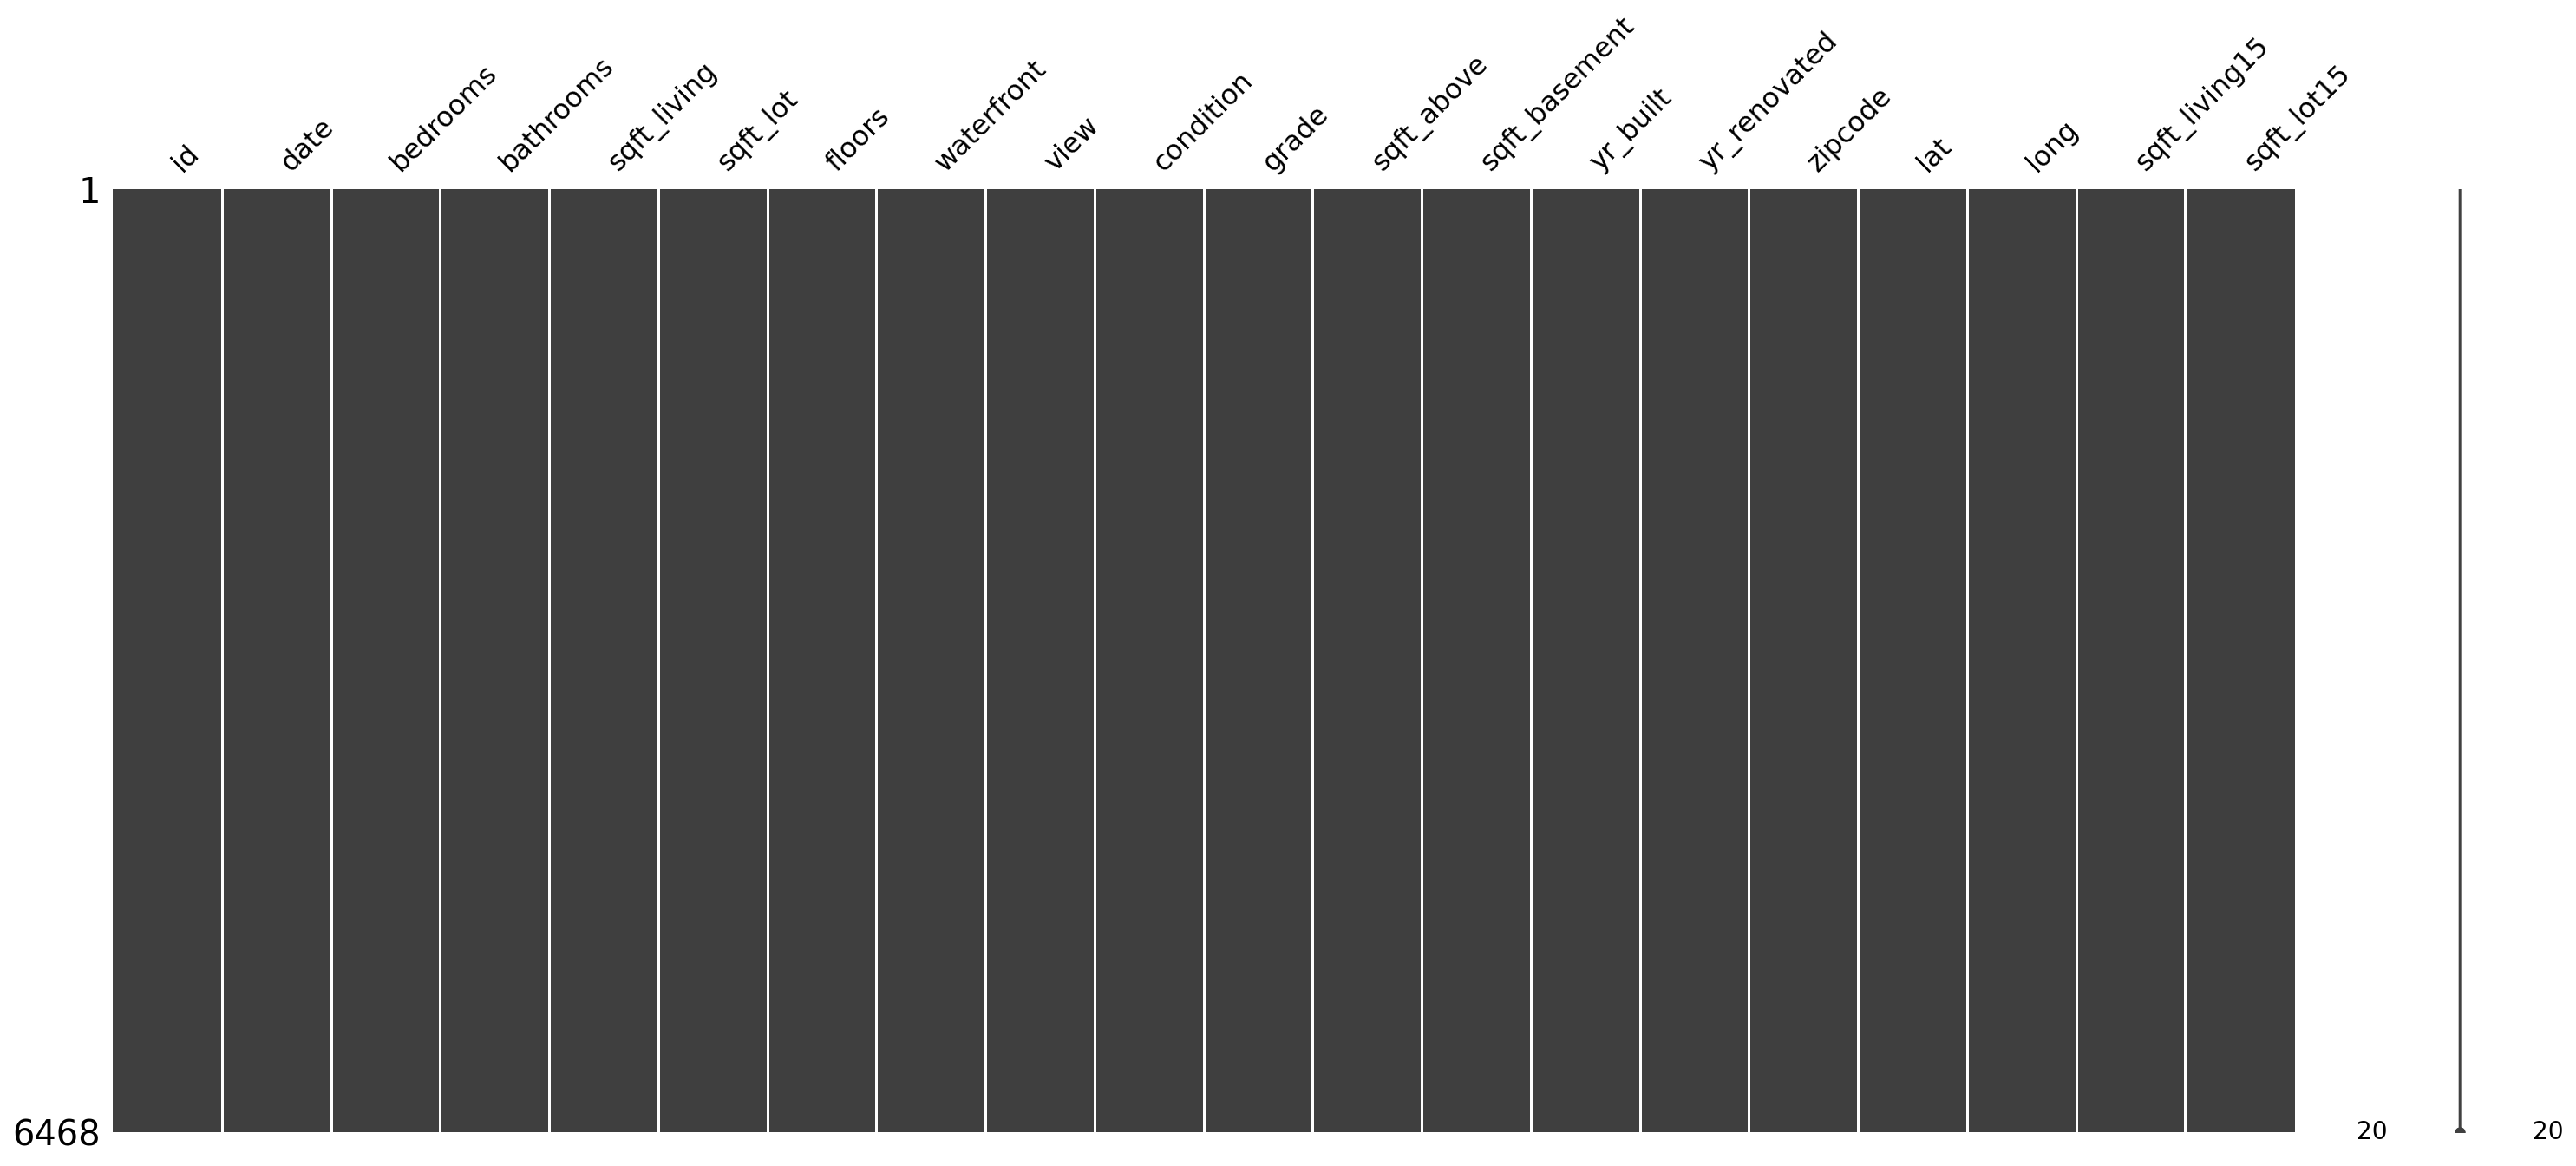

In [12]:
msno.matrix(test)

train, test데이터 모두, 결측치가 없다는 것을 데이터와 시각화를 통해 알 수 있었다.
이제 데이터의 확인이 끝났으니 데이터 전처리를 진행해보자.

___
## 2. 데이터 전처리 

In [13]:
# 정답데이터 분리
y = train['price']
train_in_y = train.copy()

# 정답데이터를 제외한 train데이터
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [14]:
# id 컬럼 삭제
del train['id']
del test['id']

print(train.columns)
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [15]:
#baseline과 달리 정수형으로 변환시키면 date도 예측을 위한 특성으로 활용가능
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) # 일까지 쓸지는 뒤에서 결정
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [16]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [17]:
train.info()
print('='*50)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

train데이터와 test데이터의 컬럼이 잘 맞게 정리된 것을 확인할 수 있다.
___
각 컬럼의 분포를 확인하여 이상치가 있는지, 더 처리해줄 것이 있는지 Kdeplot을 사용해 확인해보도록 한다.

**sns.kdeplot**

kdeplot은 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분호를 확인할 수 있도록 하는 시각화 함수이다.

https://seaborn.pydata.org/generated/seaborn.kdeplot.html

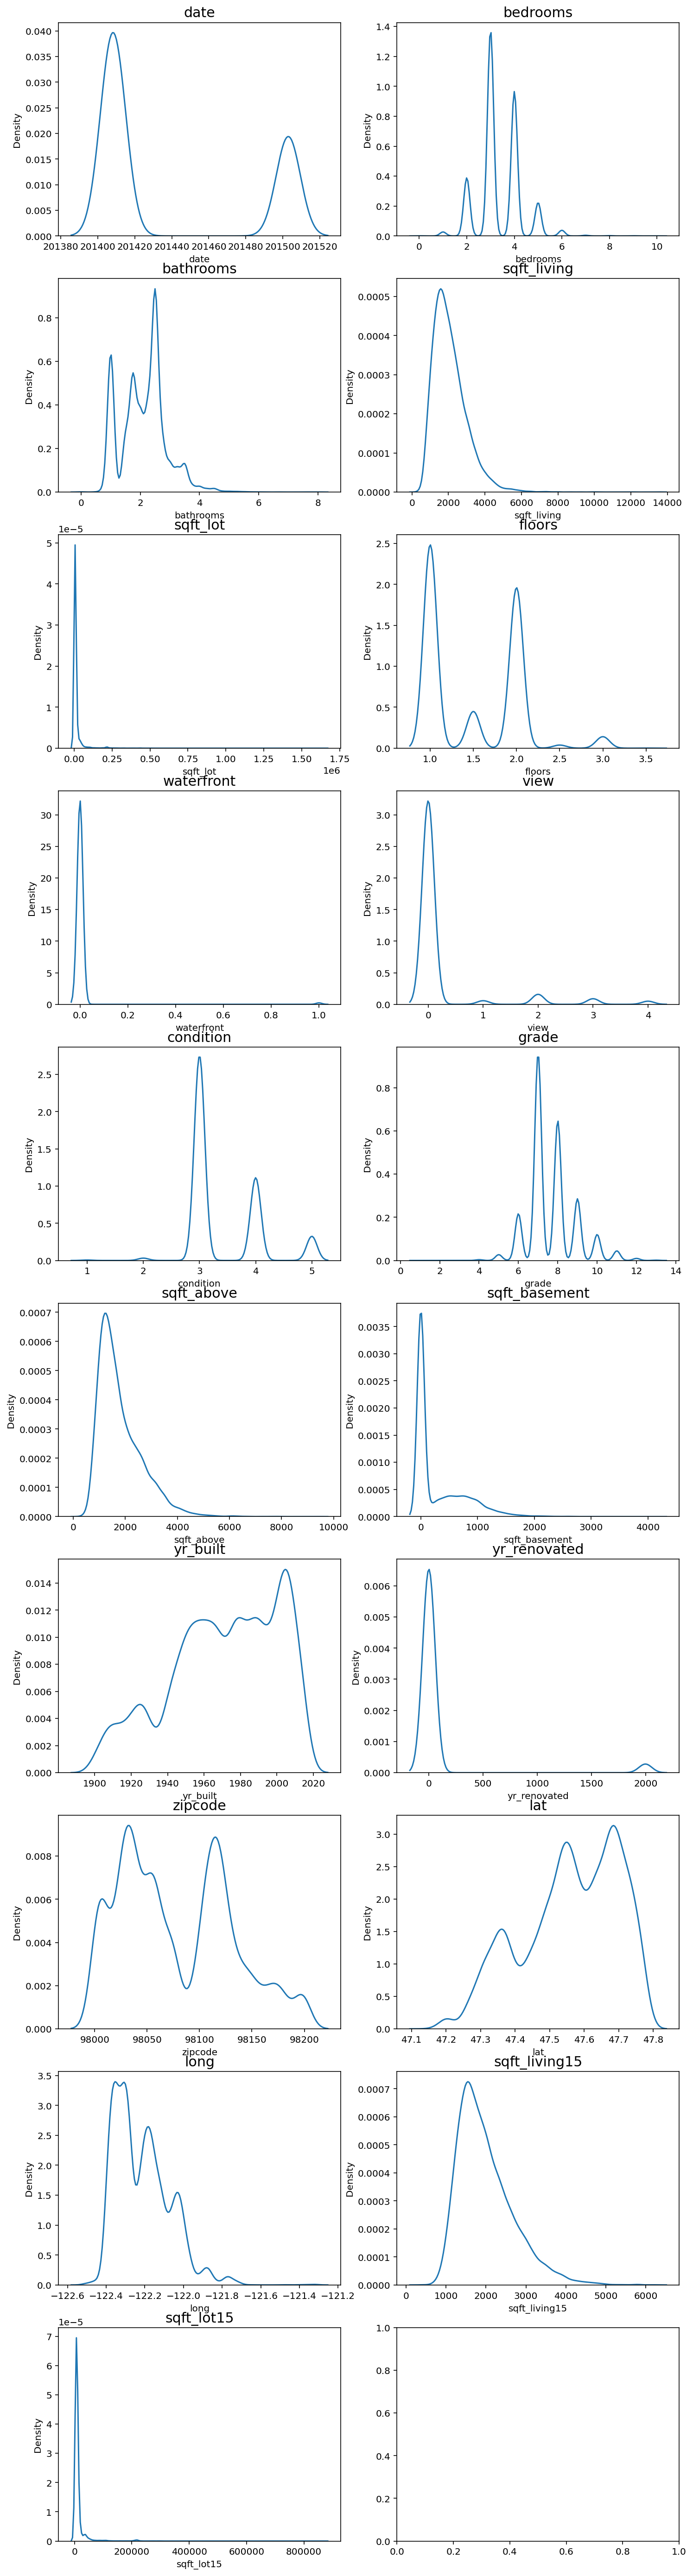

In [18]:
# train 데이터 컬럼 분포 확인
fig, ax = plt.subplots(10, 2, figsize=(12, 50))   

count = 0
columns = train.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

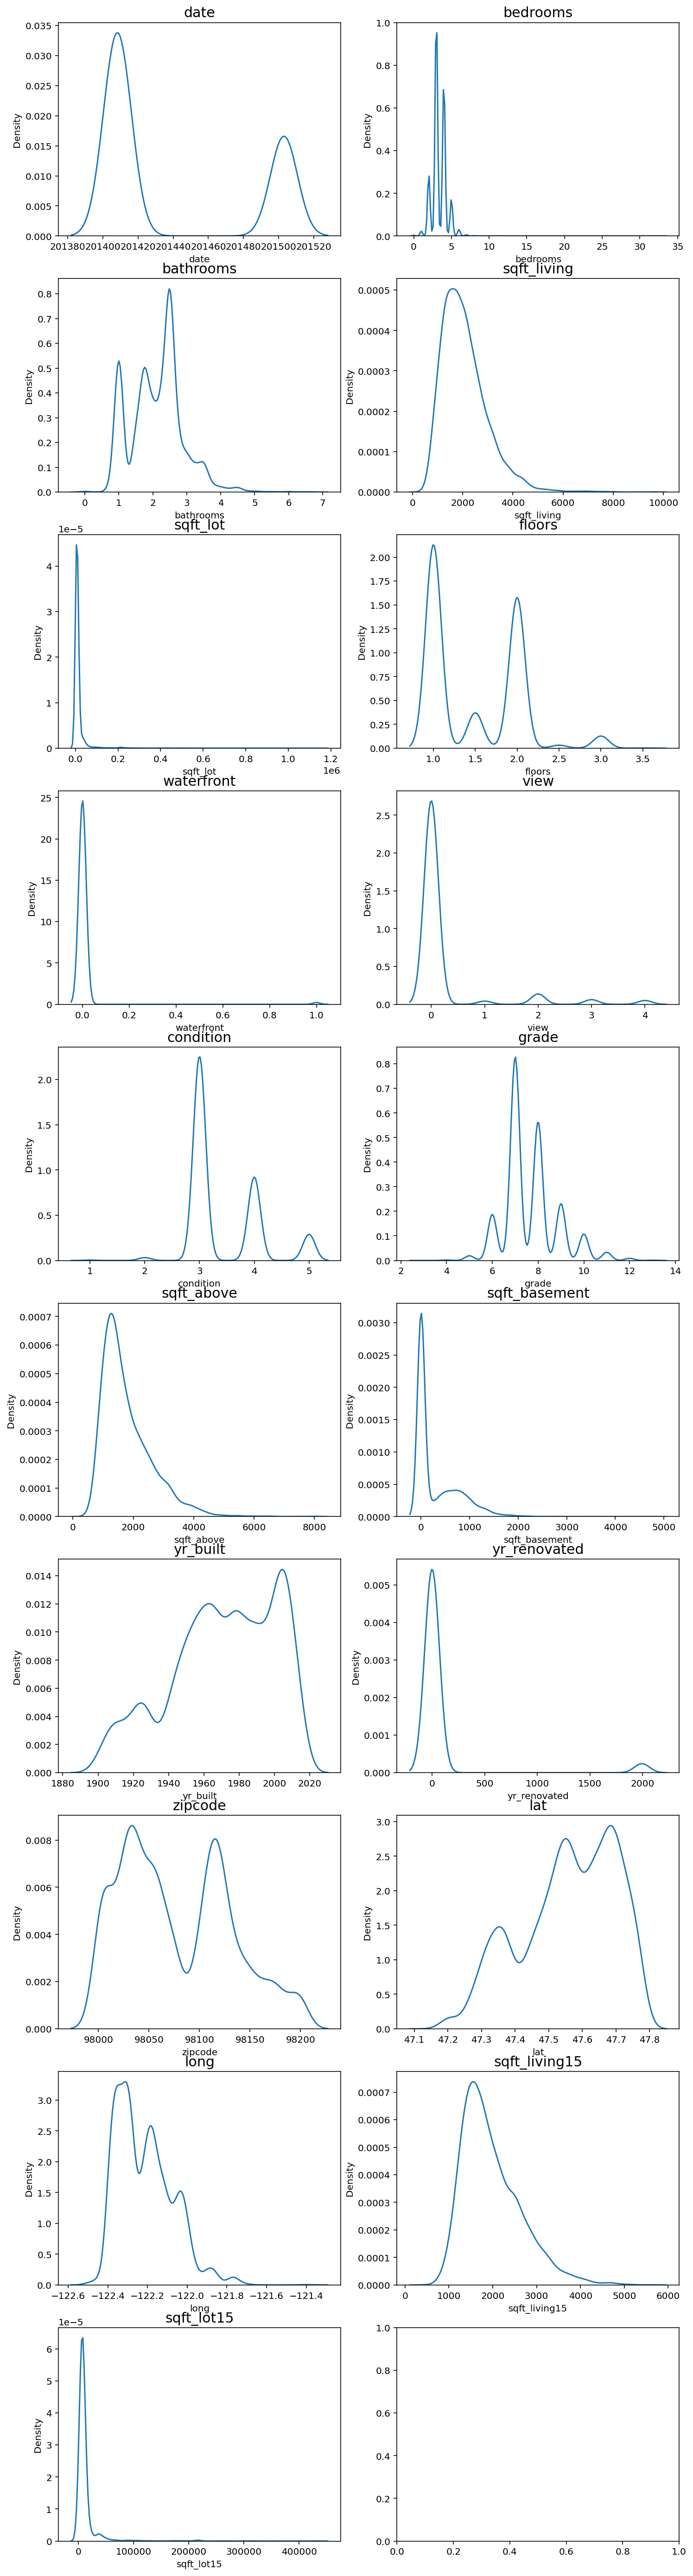

In [19]:
# test데이터 컬럼 분포확인
fig, ax = plt.subplots(10, 2, figsize=(12, 50))   

count = 0
columns = test.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data=test[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

Q. 회귀 분석을 위해서 데이터 전처리를 하는데 train 데이터와 test 데이터를 나눠서 분포 확인을 한뒤 np.log1p()함수로 로그 변환을 해주는 거랑, 두 데이터를 합쳐 분포를 확인한 뒤 로그변환한 뒤에 나눠주는 거에 차이가 있을까?

>데이터를 전처리하고 모델링하기 전에 항상 데이터의 분포를 확인하는 것은 중요합니다. 그리고 회귀 분석에서는 종속 변수와 독립 변수 간의 관계를 설명하기 위해 종속 변수를 변환하는 경우가 많습니다. 이러한 변환 중에서 로그 변환은 종속 변수의 분포를 정규 분포에 가깝게 만들어 줄 수 있기 때문에 일반적으로 많이 사용됩니다.\
train 데이터와 test 데이터를 각각 따로 분할하여 로그 변환을 한 후 모델을 학습하고 예측하는 경우와, train 데이터와 test 데이터를 합친 후 로그 변환을 한 후 다시 분리하여 모델을 학습하고 예측하는 경우, 결과는 같을 것입니다. 그러나 두 방법에는 차이점이 있습니다.\
첫 번째 방법은 train 데이터와 test 데이터를 각각 다루므로, train 데이터에서 찾은 패턴을 test 데이터에서 확인할 수 없습니다. 즉, 모델 학습에 사용되는 데이터와 모델 예측에 사용되는 데이터가 다르므로 예측 성능에 영향을 미칠 수 있습니다.\
두 번째 방법은 train 데이터와 test 데이터를 합쳐서 전체 데이터의 분포를 확인한 후 로그 변환을 하는 것이므로, 전체 데이터에 대한 패턴을 파악할 수 있습니다. 그러나 학습 데이터와 검증 데이터를 구분하여 모델 학습 및 검증을 수행해야 하므로, 학습 데이터와 검증 데이터의 분포가 서로 다르면 모델 성능이 예측되지 않을 수 있습니다.

>**따라서, 일반적으로는 train 데이터와 test 데이터를 각각 분할한 후 로그 변환을 수행하고, 그 이후에 합쳐서 모델을 학습하고 예측하는 방법이 좀 더 안정적인 방법입니다. 이 방법은 train 데이터에서 학습한 패턴을 test 데이터에서도 확인할 수 있기 때문에 모델의 일반화 성능을 더욱 잘 평가할 수 있습니다.**

- train데이터와 test데이터를 각자 학습할 지, 합쳐서 학습을 진행할지에 대한 부분을 고민을 많이 했는데, 처음부터 합치는 것보다 분리하여 로그변환하고 그 후에 합쳐서 학습하는 것이 더 좋은 결과를 가져올 것이라고 한다.
    그런데 train 데이터에만  y데이터가 있기 때문에 test 데이터를 어떻게 평가해야 할지 답을 찾지 못해서 그냥 분리하여 각각 진행만 했다.

### (1) 로그 변환

#### np.log()가 아닌 np.log1p()를 하는 이유

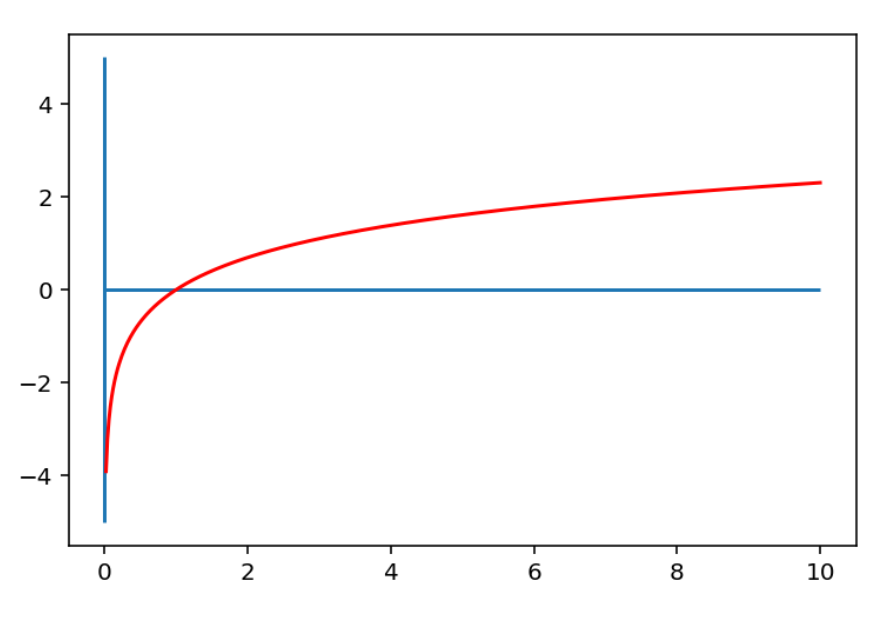

로그 함수의 특징은 0<x<1 범위에서 기울기가 매우 가파르다는 것이다.
즉, x축 구간은 (0,1)로 매우 짧은 반면, y의 구간은 (-∞, 0)으로 매우 크다
그래서 0에 가깝게 모여있는 값들이 x로 입력되면 y 값들은 매우 큰 범위로 벌어지게 된다.

0이 포함된 값이 log()함수에 대입되면 -inf, 즉 -무한대의 값을 갖게 되므로 이를 해결하기 위해 x+1의 값을 넣어주어서 이 문제를 없애준다.

In [20]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    
for c in skew_columns:
    test[c] = np.log1p(test[c].values)

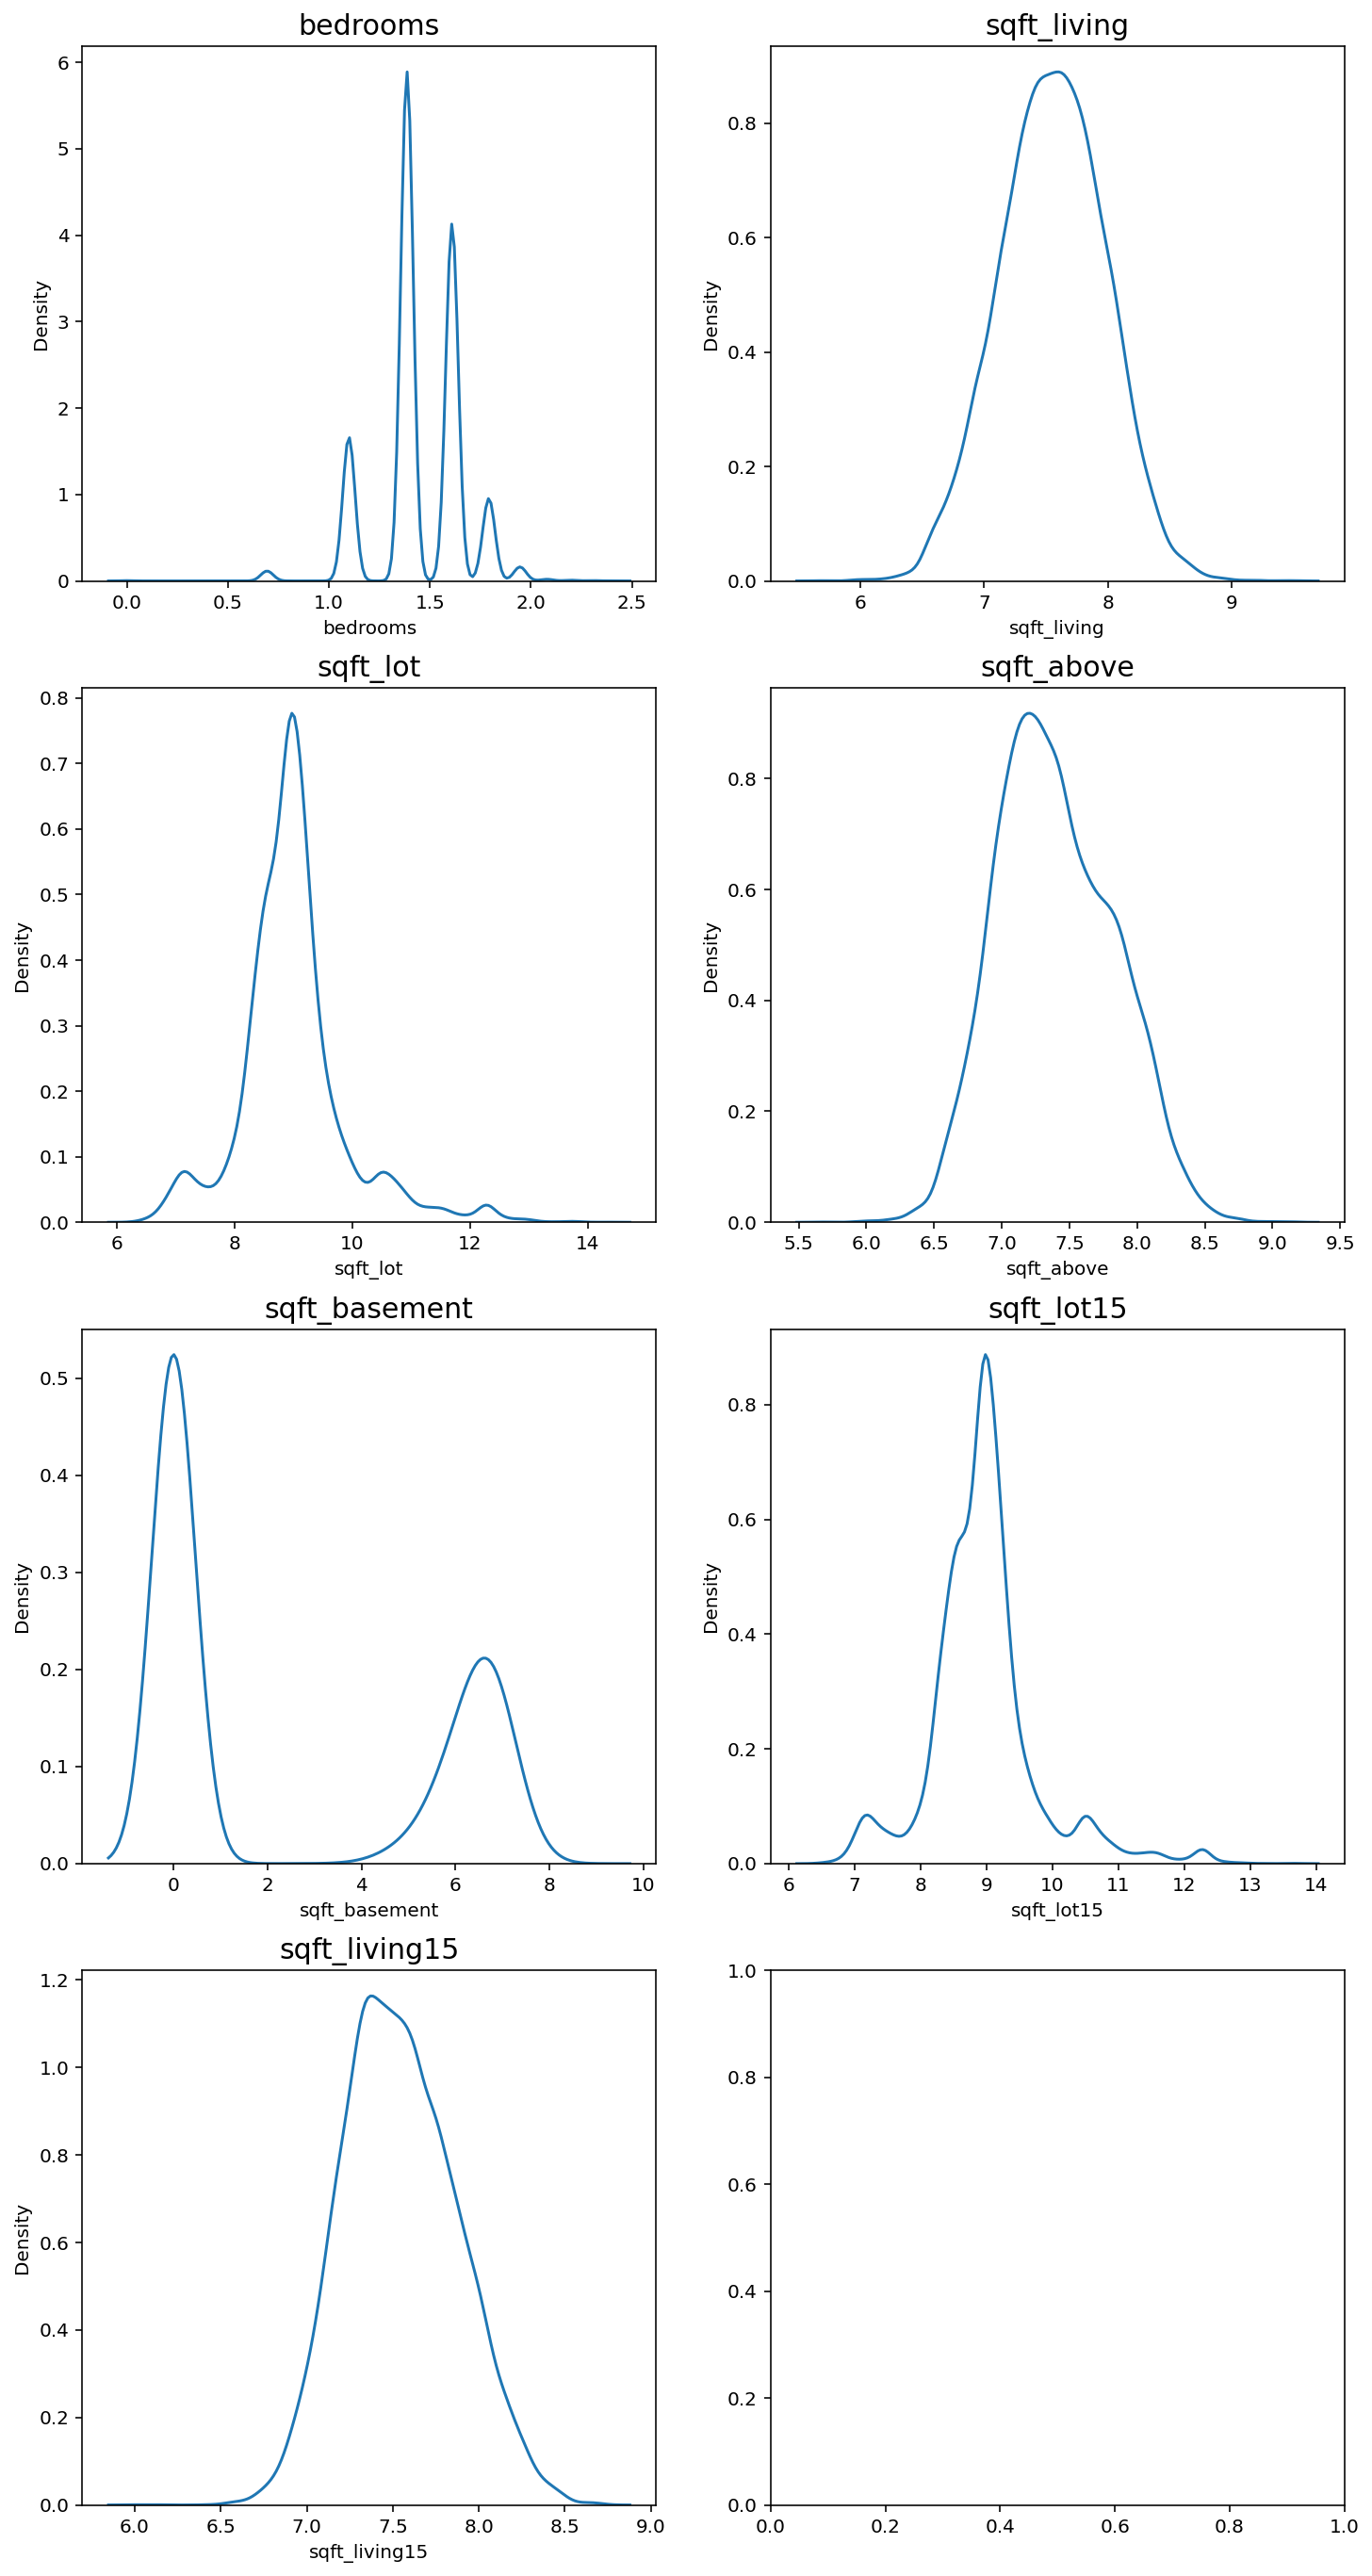

In [21]:
# train
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

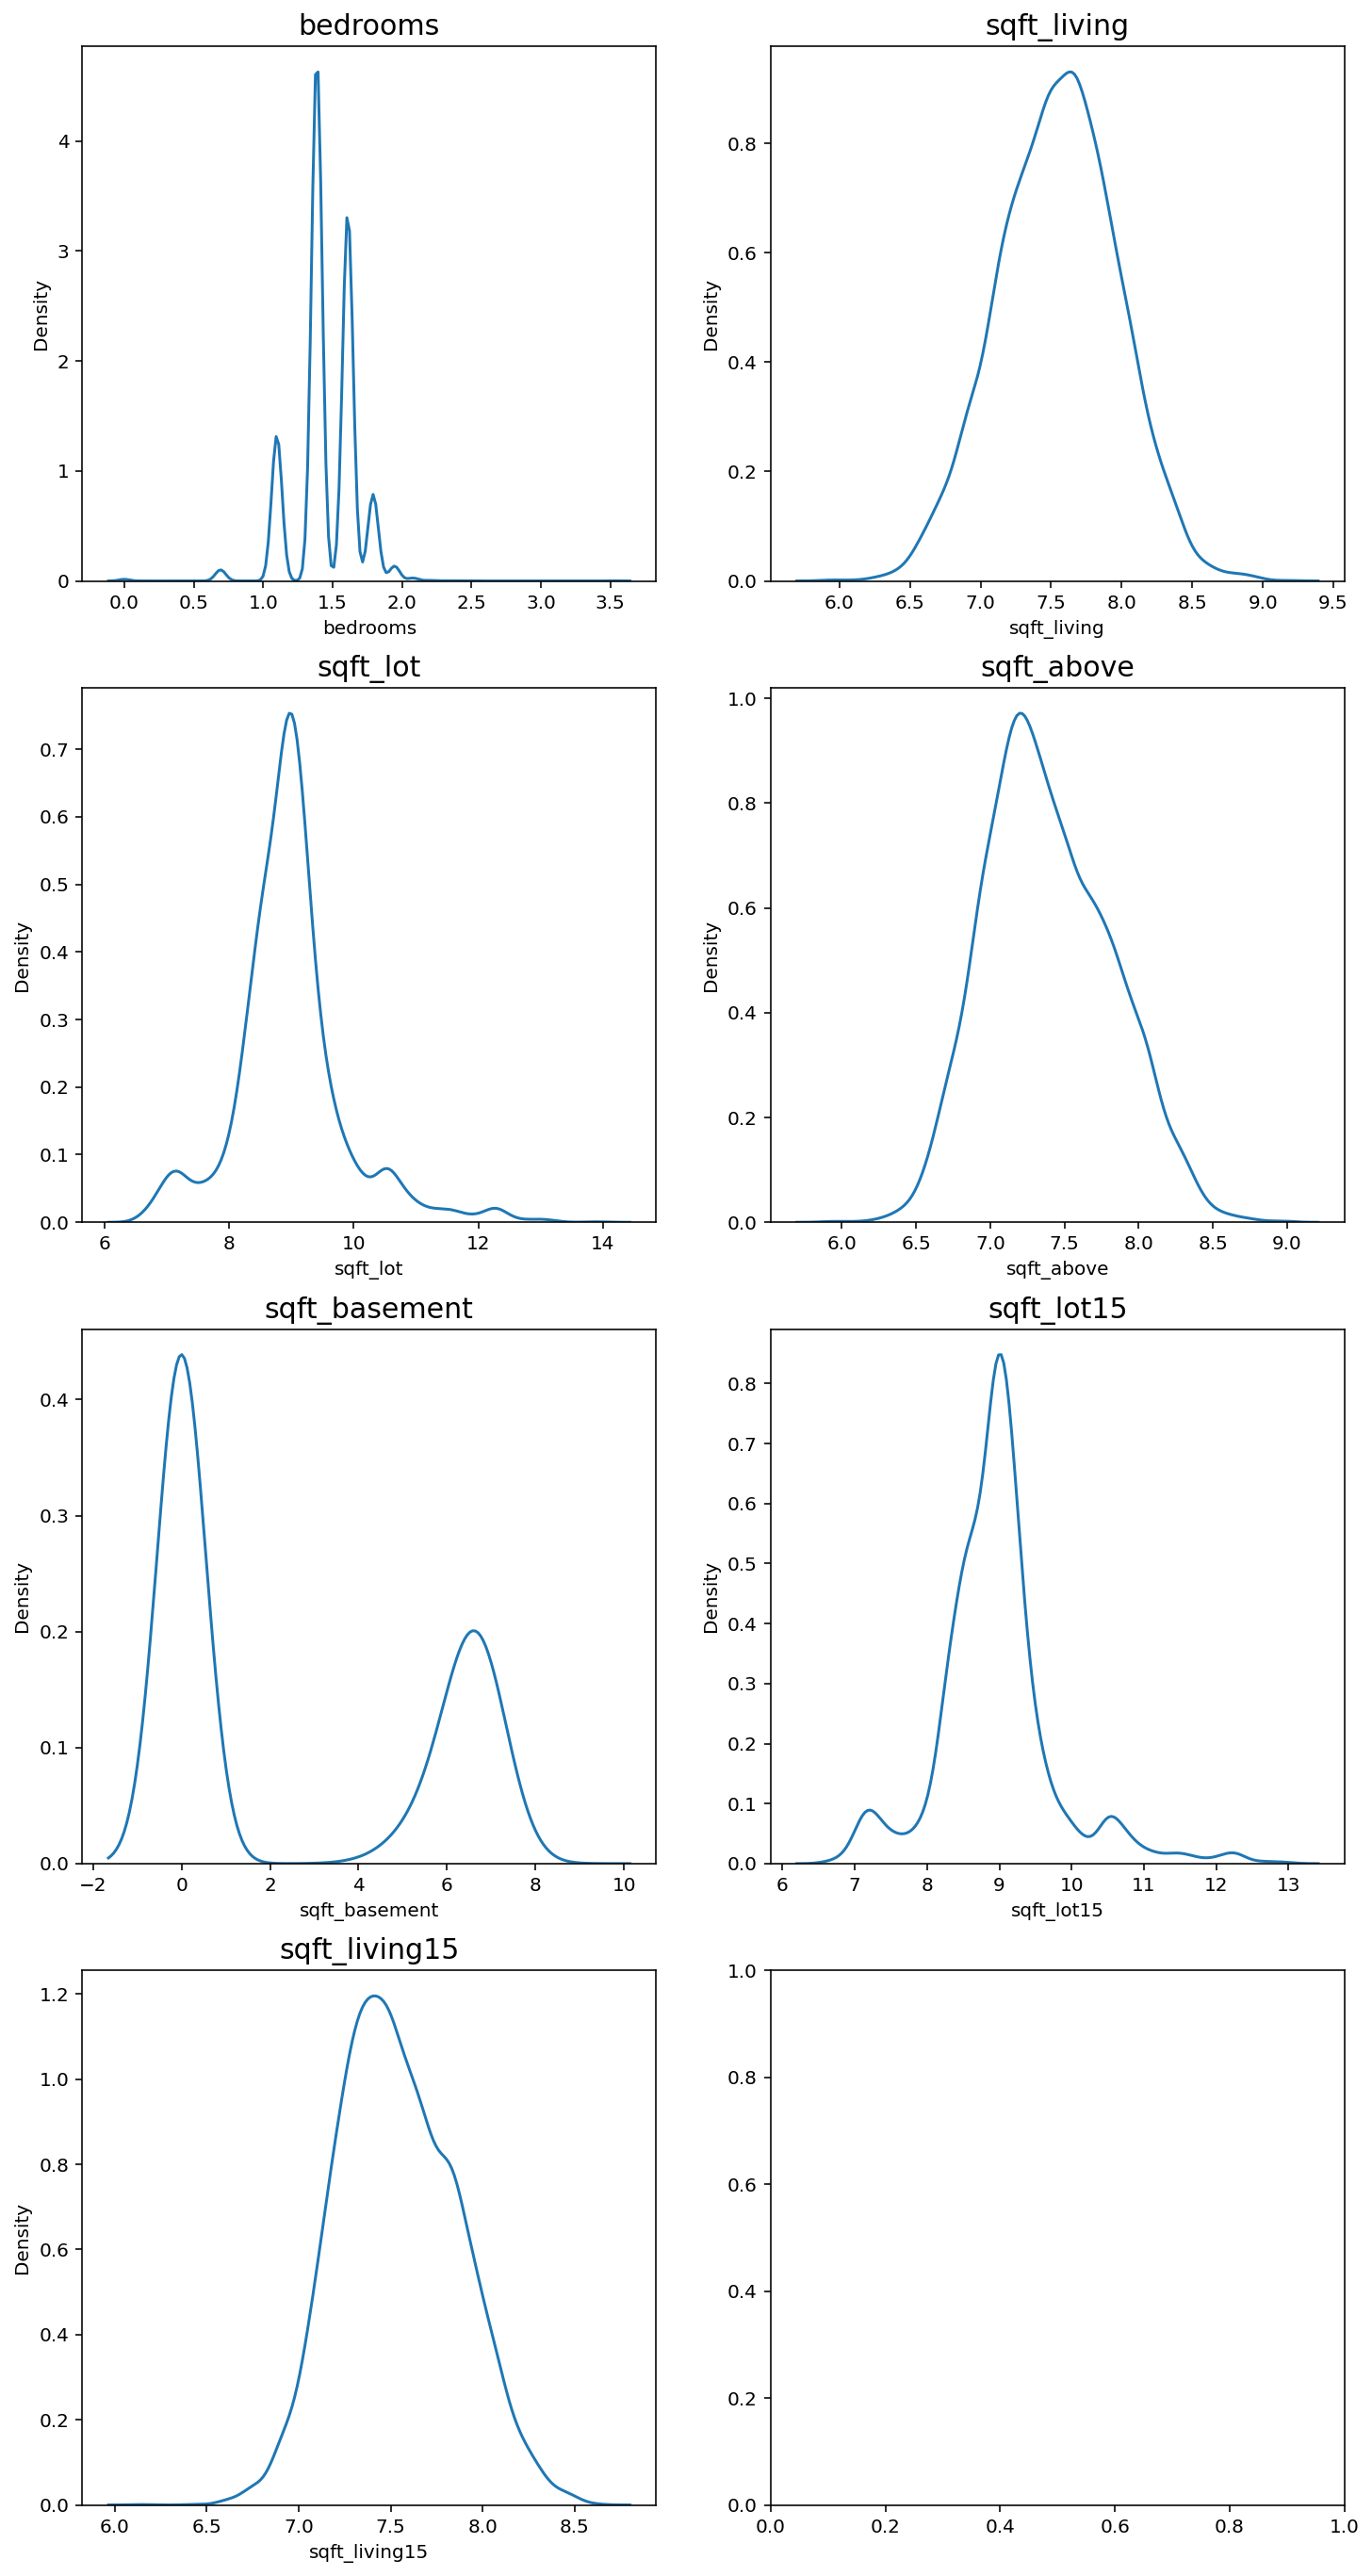

In [22]:
# test
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=test[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

대부분 치우침이 훨씬 줄어든 분포로 바뀐 것을 확인할 수 있다. 
train 데이터의 'bedrooms'는 전과 비슷한 모양이긴 하나, test 데이터의 'bedrooms'의 분포가 많이 좋아진 것을 확인할 수 있다.

이제는 y분포를 확인하고 치우침이 있다면 y데이터 또한 로그변환을 해준다.

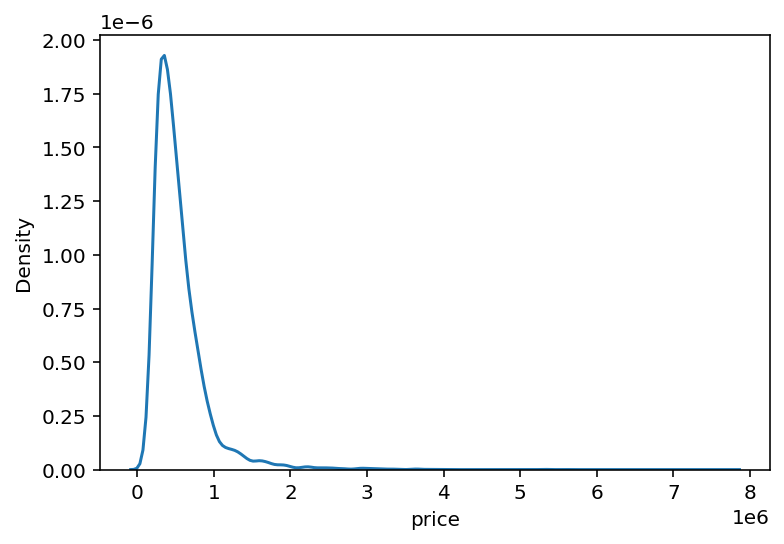

In [23]:
# y분포 확인
sns.kdeplot(y)
plt.show()

price는 왼쪽으로 크게 치우쳐 있는 형태를 보인다.

따라서 y는 np.log1p() 함수를 통해 로그 변환을 해주고, 나중에 모델이 값을 예측한 후에 다시 np.expm1()을 활용해서 되돌리는 작업을 해준다. 
>np.expm1()은 np.log1p()과는 반대로 각 원소 x마다 exp(x)-1의 값을 반환해 준다.

https://numpy.org/doc/stable/reference/generated/numpy.log1p.html
https://numpy.org/doc/stable/reference/generated/numpy.expm1.html

In [24]:
# 후에 다시 원래 스케일로 돌려줘야 함
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

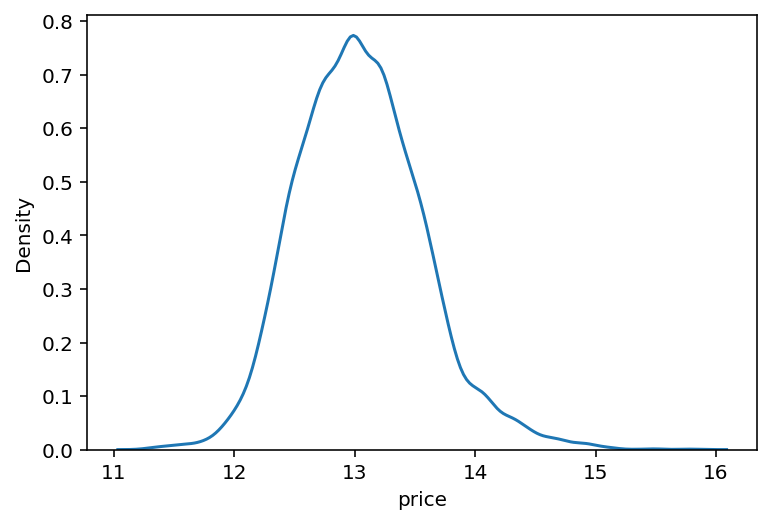

In [25]:
sns.kdeplot(y)
plt.show()

### (2) Feature engineering

In [26]:
# plt.figure(figsize=(18,8))
# sns.heatmap(train_in_y, annot=True, cmap='Pastel2')
# plt.title('', fontsize=15)
# plt.show()

price와의 상관관계를 보기 위해 heatmap을 시각화하려 했으나 feature가 너무 많아서 그런지 커널이 실행을 완료하지 못했다.
그래서 corr()함수를 통해 상관계수를 확인하고 상관도가 높은 10개의 feature를 뽑아서 학습시켜보는 건 어떨까 생각했다.

In [27]:
# price 컬럼을 삭제하지 않은 train_in_y 데이터를 사용하여 pirce와의 상관도 확인
del train_in_y['id']
train_in_y['date'] = train_in_y['date'].apply(lambda i: i[:6]).astype(int) # 일까지 쓸지는 뒤에서 결정
print(train_in_y.corr(method='pearson'))

                   date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
date           1.000000  0.007717 -0.002696  -0.022810    -0.022119  0.007500   
price          0.007717  1.000000  0.323672   0.525479     0.702899  0.096793   
bedrooms      -0.002696  0.323672  1.000000   0.530548     0.596974  0.033475   
bathrooms     -0.022810  0.525479  0.530548   1.000000     0.755853  0.089308   
sqft_living   -0.022119  0.702899  0.596974   0.755853     1.000000  0.176500   
sqft_lot       0.007500  0.096793  0.033475   0.089308     0.176500  1.000000   
floors        -0.020891  0.262588  0.189532   0.508649     0.363193  0.001535   
waterfront    -0.001742  0.265738 -0.004819   0.075452     0.108137  0.025584   
view           0.013986  0.400806  0.085703   0.187488     0.282821  0.080441   
condition     -0.047028  0.039740  0.034885  -0.125907    -0.054213 -0.002099   
grade         -0.023233  0.667211  0.375286   0.666278     0.762543  0.119906   
sqft_above    -0.019422  0.6

In [28]:
# 피처 10개 선택
train_10 = train.loc[:, ['sqft_living',
                         'grade',
                         'sqft_above',
                         'sqft_living15',
                         'bathrooms',
                         'view',
                         'bedrooms',
                         'sqft_basement',
                         'lat',
                         'waterfront']]

In [29]:
test_10 = test.loc[:, ['sqft_living',
                         'grade',
                         'sqft_above',
                         'sqft_living15',
                         'bathrooms',
                         'view',
                         'bedrooms',
                         'sqft_basement',
                         'lat',
                         'waterfront']]

- 상관도가 높은 순으로 10개만 피처로 뽑아 저장했다. 모델링을 진행하며 성능이 좋아지는지 확인해보자.
___
## 3. 모델링


In [30]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [31]:
# rmse 함수 정의
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [32]:
# 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

1. XGBoost

2. LihgtGBMM

3. RandomForest

4. GBoost

In [33]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값 
random_state=2020        # 고정값 세팅

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [34]:
# 모델 학습 및 평가 함수로 정의
def get_scores(models, train, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__ 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=17, test_size=0.2)   
        model.fit(X_train, y_train)    
        y_pred = model.predict(X_test)    
        df[model_name] = rmse(y_test, y_pred)    
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,157341.970651
RandomForestRegressor,145665.995155
XGBRegressor,137505.515776
LGBMRegressor,132522.678678


In [35]:
get_scores(models, train_10, y)

,RMSE
GradientBoostingRegressor,175153.154508
RandomForestRegressor,174511.257029
LGBMRegressor,164623.002057
XGBRegressor,162975.163328


상관도가 높은 피처를 골라서 진행했을 때 오히려 RMSE의 점수가 올라간 것을 알 수 있다.
이 방법은 개선방안이 아닌 것 같으니 폐기하고, 상관도가 -였던 피처가 하나 있었다.
그 피처만 삭제 한 뒤 다시 진행해보자.

In [36]:
train_m1 = train.drop('zipcode', axis=1)
test_m1 = test.drop('zipcode', axis=1)

get_scores(models, train_m1, y)

,RMSE
GradientBoostingRegressor,153749.797489
RandomForestRegressor,146135.655370
LGBMRegressor,131050.724620
XGBRegressor,123443.794241


- RSME 값이 줄어들었다.\
  그럼 train, test의 값을 m1으로 변경한 뒤 모델학습을 진행한다. 

In [37]:
train = train_m1
test = test_m1

In [38]:
train_m2 = train.drop('date', axis=1)
test_m2 = test.drop('date', axis=1)

get_scores(models, train_m2, y)

,RMSE
GradientBoostingRegressor,154524.084423
RandomForestRegressor,145779.524888
LGBMRegressor,132712.069040
XGBRegressor,128239.709901


- 'zipcode'다음으로 상관도가 낮은 'date'열도 삭제해 보았으나 'zipcode'열만 삭제한 것이 더 좋은 것 같으므로 그대로 진행한다.

### (1) 하이퍼파라미터 조정


**GridSearchCV vs RandomSearch**

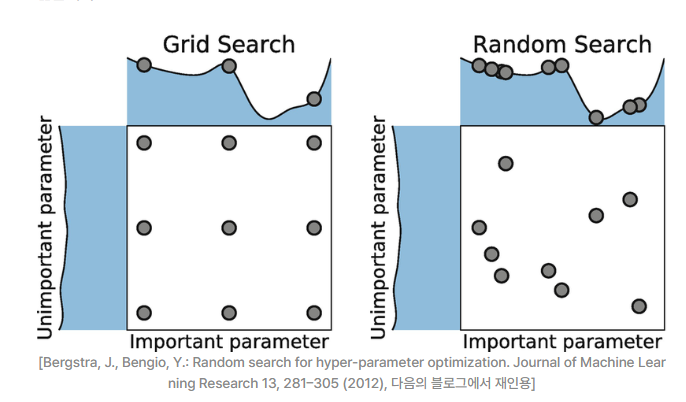

GridSearchCV 인자
- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

**모델들의 하이퍼파라미터**

LGBM 하이퍼파라미터
- max_depth : 의사 결정 나무의 깊이, 정수 사용
- learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
- n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
- num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수

XGBoost의 하이퍼파라미터
- objective (기본값 binary:logistic) : 이진분류 (다중분류: multi:softmax)
- max_depth (기본값 6) : 최대 한도 깊이
- learning_rate (기본값 0.1) : 학습률
- n_estimators (기본값 100) : 트리의 수
- subsample (기본값 1) : 훈련 샘플 개수의 비율
- colsample_bytree (기본값 1) : 특성 개수의 비율
- n_jobs (기본값 1) : 사용 코어 수 (-1: 모든 코어를 다 사용)

RandomForeset 하이퍼파라미터
- n_estimators (기본값 100) : 트리의 수
- criterion (기본값 gini) : 불순도 지표
- max_depth (기본값 None) : 최대 한도 깊이
- min_samples_split (기본값 2) : 자식 노드를 갖기 위한 최소한의 데이터 수
- min_samples_leaf (기본값 1) : 리프 노드가 되기 위한 최소 샘플 수

GBM 하이퍼파라미터
- loss(기본값 'deviance'): 경사 하강법에서 사용할 손실 함수 지정
- learning_rate(기본값 0.1): 학습률
- n_estimators(기본값 100): 약한 학습기의 개수.
- subsample(기본값 1): weak learner가 학습에 사용하는 데이터 샘플링 비율

In [71]:
## GradientBoostingRegressor
param_grid_gb = {'learning_rate':[0.01, 0.1],
                 'n_estimators':[100, 200, 300, 400],
                 'subsample':[1, 2, 3, 4, 5]}

## XGBRegressor
param_grid_xgb = {'max_depth':[6, 8, 10],
                  'learning_rate':[0.01, 0.1, 1],
                  'n_estimators':[100, 200, 300, 400]}
                  

## LGBMRegressor
param_grid_lgbm = {'max_depth':[10, 20, 30, 40, 50],
                   'learning_rate':[0.01, 0.1, 1],
                   'n_estimators':[100, 200, 300, 400],
                   'num_leaves':[1, 4, 7, 10, 13]}

## RandomForestRegressor
param_grid_rf = {'n_estimators':[100, 200, 300, 400],
                 'max_depth':[10, 20, 30, 40, 50],
                 'min_samples_split':[2, 4, 6],
                 'min_samples_leaf':[1, 3, 5]}

### 그리드 서치의 시간이 오래 걸리므로 하이퍼파라미터 중 일부만 선택하여 튜닝하였다.

In [49]:
# 위에서 지정한 모델의 변수명
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

In [50]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, 
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              cv=5,
                              verbose=verbose,
                              n_jobs=n_jobs)
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results


- 위에서 GridSearchCV로 grid_model 모델을 초기화할 때, scoring 인자에neg_mean_squared_error(MSE에 음수를 취한 값)을 넣었으므로 음수를 다시 곱해주어서 RMSE를 만들어 주어야 하는데, 그리드탐색을 하면서 전에 로그로 변환했던 값을 복원하지 않았기 때문에 실제로는 RMSLE 값이 반환된다.


https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [51]:
my_GridSearch(gboost, train, y, param_grid_gb, verbose=2, n_jobs=5)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
[CV] END .learning_rate=0.001, n_estimators=100, subsample=1; total time=  13.9s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=2; total time=   0.0s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=2; total time=   0.0s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=2; total time=   0.0s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=3; total time=   0.0s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=3; total time=   0.0s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=3; total time=   0.0s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=4; total time=   0.1s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=4; total time=   0.0s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=4; total time=   0.0s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=5; total time=   0.0s
[CV] END .learning_rate=0.001, n_estimators=10

,learning_rate,n_estimators,subsample,score,RMSLE
98,0.1,500,1,-0.028202,0.167935
91,0.1,400,1,-0.028474,0.168744
84,0.1,300,1,-0.029077,0.170520
77,0.1,200,1,-0.030197,0.173774
70,0.1,100,1,-0.034114,0.184701
...,...,...,...,...,...
135,1.0,500,3,NaN,NaN
136,1.0,500,4,NaN,NaN
137,1.0,500,5,NaN,NaN
138,1.0,500,6,NaN,NaN


In [63]:
# 모델 학습 RMSLE = 0.167935
model_gb = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500, subsample=1, random_state=random_state)
model_gb.fit(train, y)

#예측결과 생성
prediction_gb = model_gb.predict(test)
prediction_gb

# 원래 스케일로 되돌리기
prediction_gb = np.expm1(prediction_gb)
prediction_gb

array([ 535416.46635278,  413894.22070727, 1424478.42242199, ...,
        454201.29902506,  333505.4304528 ,  454088.06613658])

In [58]:
my_GridSearch(xgboost, train, y, param_grid_xgb, verbose=2, n_jobs=5)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1; total time=  32.1s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1; total time=  56.7s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=1; total time= 1.7min
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=2; total time=   0.0s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=2; total time=   0.0s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=2; total time=   0.1s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=2; total time=   0.0s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=2; total time=   0.1s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=3; total time=

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,score,RMSLE
85,1,0.1,8,200,1,-0.026580,0.163035
75,1,0.1,6,400,1,-0.026583,0.163044
70,1,0.1,6,300,1,-0.026600,0.163096
90,1,0.1,8,300,1,-0.026673,0.163318
95,1,0.1,8,400,1,-0.026787,0.163668
...,...,...,...,...,...,...,...
715,4,1.0,10,400,1,NaN,NaN
716,4,1.0,10,400,2,NaN,NaN
717,4,1.0,10,400,3,NaN,NaN
718,4,1.0,10,400,4,NaN,NaN


[CV] END colsample_bytree=4, learning_rate=1, max_depth=8, n_estimators=300, subsample=2; total time=   0.0s
[CV] END colsample_bytree=4, learning_rate=1, max_depth=8, n_estimators=300, subsample=4; total time=   0.1s
[CV] END colsample_bytree=4, learning_rate=1, max_depth=8, n_estimators=300, subsample=4; total time=   0.1s
[CV] END colsample_bytree=4, learning_rate=1, max_depth=8, n_estimators=400, subsample=1; total time=   0.1s
[CV] END colsample_bytree=4, learning_rate=1, max_depth=8, n_estimators=400, subsample=1; total time=   0.1s
[CV] END colsample_bytree=4, learning_rate=1, max_depth=8, n_estimators=400, subsample=3; total time=   0.1s
[CV] END colsample_bytree=4, learning_rate=1, max_depth=8, n_estimators=400, subsample=3; total time=   0.1s
[CV] END colsample_bytree=4, learning_rate=1, max_depth=8, n_estimators=400, subsample=4; total time=   0.1s
[CV] END colsample_bytree=4, learning_rate=1, max_depth=8, n_estimators=400, subsample=4; total time=   0.1s
[CV] END colsample_

In [64]:
# 모델 학습 RMSLE = 0.163035
model_xgb = XGBRegressor(colsample_bytree=1, learning_rate=0.1, max_depth=8, n_estimators=200, subsample=1, random_state=random_state)
model_xgb.fit(train, y)

#예측결과 생성
prediction_xgb = model_xgb.predict(test)
prediction_xgb

# 원래 스케일로 되돌리기
prediction_xgb = np.expm1(prediction_xgb)
prediction_xgb

array([ 521848.47,  440646.  , 1335473.8 , ...,  466517.47,  340960.2 ,
        444021.56], dtype=float32)

In [65]:
my_GridSearch(lightgbm, train, y, param_grid_lgbm, verbose=2, n_jobs=5)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=4; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=7; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=10; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=13; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=4; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=20

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=4; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=7; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=10; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=13; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=4; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=7; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=10; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=13; total time=   2.8s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=4; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=7; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=10; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=13; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=4; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=7; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=10; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=13; total time=   2.7s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=4; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=7; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=10; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=13; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=4; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=7; total time=   2.2s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=10; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=13; total time=   2.5s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, num_leaves=4; total time=   2.2s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=40, n_estimators=300, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=40, n_estimators=300, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=40, n_estimators=300, num_leaves=4; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=40, n_estimators=300, num_leaves=7; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=40, n_estimators=300, num_leaves=7; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=40, n_estimators=300, num_leaves=10; total time=   3.7s
[CV] END learning_rate=0.01, max_depth=40, n_estimators=300, num_leaves=13; total time=   3.3s
[CV] END learning_rate=0.01, max_depth=40, n_estimators=400, num_leaves=4; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=40, n_estimators=400, num_leaves=7; total time=   3.6s
[CV] END learning_rate=0.01, max_depth=40, n_estimators=400, num_leaves=10; total time=   4.1s
[CV] END learning_rate=0.01, max_depth=40, n_estimators=4

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



[CV] END learning_rate=0.01, max_depth=40, n_estimators=400, num_leaves=4; total time=   2.6s
[CV] END learning_rate=0.01, max_depth=40, n_estimators=400, num_leaves=7; total time=   4.0s
[CV] END learning_rate=0.01, max_depth=40, n_estimators=400, num_leaves=10; total time=   3.5s
[CV] END learning_rate=0.01, max_depth=40, n_estimators=400, num_leaves=13; total time=   5.1s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=100, num_leaves=4; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=100, num_leaves=7; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=100, num_leaves=10; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=100, num_leaves=13; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=200, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=200, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



[CV] END learning_rate=0.01, max_depth=50, n_estimators=300, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=300, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=300, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=300, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=300, num_leaves=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=300, num_leaves=4; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=300, num_leaves=7; total time=   2.9s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=300, num_leaves=10; total time=   3.5s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=300, num_leaves=13; total time=   4.1s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=400, num_leaves=4; total time=   2.8s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=40

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=50, n_estimators=400, num_leaves=4; total time=   2.6s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=400, num_leaves=7; total time=   4.0s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=400, num_leaves=10; total time=   4.5s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=400, num_leaves=13; total time=   3.9s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=4; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=7; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=10; total time=   1.4s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=13; total time=   1.5s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=7; total time=   1.9s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=10; total time=   1.4s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, n

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=40, n_estimators=100, num_leaves=7; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=100, num_leaves=10; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=100, num_leaves=13; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=200, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=200, num_leaves=1; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=200, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=200, num_leaves=1; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=200, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=200, num_leaves=4; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=200, num_leaves=7; total time=   1.5s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=200, num_leav

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=40, n_estimators=300, num_leaves=7; total time=   2.4s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=300, num_leaves=10; total time=   2.6s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=300, num_leaves=13; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=400, num_leaves=4; total time=   2.2s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=400, num_leaves=7; total time=   2.2s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=400, num_leaves=10; total time=   2.5s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=400, num_leaves=13; total time=   3.5s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=4; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=4; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=7; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=100, num_le

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



[CV] END learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=7; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=10; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=13; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=200, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=200, num_leaves=1; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=200, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=200, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=200, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=200, num_leaves=4; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=200, num_leaves=4; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=200, num_leav

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=40, n_estimators=200, num_leaves=10; total time=   1.9s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=200, num_leaves=13; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=300, num_leaves=4; total time=   1.5s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=300, num_leaves=7; total time=   2.7s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=300, num_leaves=10; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=300, num_leaves=13; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=400, num_leaves=4; total time=   1.8s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=400, num_leaves=7; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=400, num_leaves=10; total time=   4.0s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=400, num_leaves=13; total time=   4.0s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=100, num_

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
159,0.1,30,400,13,-0.026636,0.163205
199,0.1,50,400,13,-0.026636,0.163205
179,0.1,40,400,13,-0.026636,0.163205
139,0.1,20,400,13,-0.026636,0.163205
119,0.1,10,400,13,-0.026729,0.163491
...,...,...,...,...,...,...
275,1.0,40,400,1,NaN,NaN
280,1.0,50,100,1,NaN,NaN
285,1.0,50,200,1,NaN,NaN
290,1.0,50,300,1,NaN,NaN


[CV] END learning_rate=1, max_depth=40, n_estimators=100, num_leaves=7; total time=   0.7s
[CV] END learning_rate=1, max_depth=40, n_estimators=100, num_leaves=10; total time=   0.8s
[CV] END learning_rate=1, max_depth=40, n_estimators=100, num_leaves=13; total time=   0.8s
[CV] END learning_rate=1, max_depth=40, n_estimators=200, num_leaves=4; total time=   1.1s
[CV] END learning_rate=1, max_depth=40, n_estimators=200, num_leaves=7; total time=   1.2s
[CV] END learning_rate=1, max_depth=40, n_estimators=200, num_leaves=7; total time=   1.3s
[CV] END learning_rate=1, max_depth=40, n_estimators=200, num_leaves=10; total time=   1.3s
[CV] END learning_rate=1, max_depth=40, n_estimators=200, num_leaves=13; total time=   1.9s
[CV] END learning_rate=1, max_depth=40, n_estimators=300, num_leaves=4; total time=   2.1s
[CV] END learning_rate=1, max_depth=40, n_estimators=300, num_leaves=7; total time=   2.1s
[CV] END learning_rate=1, max_depth=40, n_estimators=300, num_leaves=10; total time=  

In [66]:
# 모델 학습 RMSLE = 0.163205
model_lgbm = LGBMRegressor(learning_rate=0.1, max_depth=30, n_estimators=400, num_leaves=13, random_state=random_state)
model_lgbm.fit(train, y)

#예측결과 생성
prediction_lgmb = model_lgbm.predict(test)
prediction_lgmb

# 원래 스케일로 되돌리기
prediction_lgmb = np.expm1(prediction_lgmb)
prediction_lgmb

array([ 482382.70711057,  477157.0796992 , 1458299.25944763, ...,
        464449.91419744,  316317.70252848,  417138.27083965])

In [72]:
my_GridSearch(rdforest, train, y, param_grid_rf, verbose=2, n_jobs=5)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


KeyboardInterrupt: 

In [73]:
# 모델 학습 RMSLE = 
model_rf = RandomForestRegressor(random_state=random_state)
model_rf.fit(train, y)

#예측결과 생성
prediction_rf = model_rf.predict(test)
prediction_rf

# 원래 스케일로 되돌리기
prediction_rf = np.expm1(prediction_rf)
prediction_rf

array([ 458440.98139921,  494676.92987098, 1297408.75219602, ...,
        456981.30072368,  327105.93922233,  440492.12472659])

- 랜덤 포레스트의 그리드 서치가 너무 오래걸려서 랜덤포레스트는 하이퍼파라미터를 진행하지 않고 기본값으로 진행하였다.

- 교차 검증과 블렌딩을 거쳐서 제출 데이터의 스케일을 돌리는 작업을 밑에서 다시 해주어야 하지만, 점수 변화를 확인하기 위해 계속 변환하며 진행하였다.

### (2) Cross Validation

In [74]:
rdforest.__class__.__name__

'RandomForestRegressor'

In [75]:
model_gb = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500, subsample=1, random_state=random_state)
model_xgb = XGBRegressor(colsample_bytree=1, learning_rate=0.1, max_depth=8, n_estimators=200, subsample=1, random_state=random_state)
model_lgbm = LGBMRegressor(learning_rate=0.1, max_depth=30, n_estimators=400, num_leaves=13, random_state=random_state)


models = [{'model':model_gb, 'name':'GradientBoosting'}, {'model':model_xgb, 'name':'XGBoost'},
          {'model':model_lgbm, 'name':'LightGBM'},{'model':model_rf, 'name':'RandomForestRegressor'}]


In [76]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")


get_cv_score(models)

Model: GradientBoosting, CV score:0.8983
Model: XGBoost, CV score:0.9043
Model: LightGBM, CV score:0.9040
Model: RandomForestRegressor, CV score:0.8842


- cross_val_score() 함수는 회귀모델을 전달할 경우에 R2 점수를 반환한다.
    R2은 1에 가까운 점수가 나올 수록 좋은 성능을 가진 것으로 모두 1에 가까운 점수로 보아 괜찮은 성능을 보여주고 있는 것으로 보인다.
    그 중 XGBoost 모델의 성능이 가장 좋아보인다.

### (3) Blending

앙상블(Ensemble) 학습이라고도 하는 블렌딩 기법은 여러 개의 학습 알고리즘을 사용하고, 그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법이다.

앙상블 학습의 유형에는 Averaging, Voting, Bagging, Boosting, Stacking 등이 있는데, 회귀 모델에서는 에버리징(Averaging)을 사용한다.

에버리징에는 simple averaging과 weighted averaging 두 가지가 있다.
simple averaging은 각 예측값을 평균을 내어 사용하는 것으로 경우에 따라 과대적합을 줄여주고, 더 부드러운 회귀모델을 만들어준다.
weighted averaging은 각 모델별로 가중치를 두어 평균을 내는 방식이다.

이번 프로젝트에서는 simple averaging을 사용해 혹시 모를 과대적합의 가능성을 없애도록 한다.

In [77]:
def AveragingBlending(models, train, y, X_test):
    for m in models : 
        m['model'].fit(train.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(X_test.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [78]:
y_pred = AveragingBlending(models, train, y, test)
print(len(y_pred))
y_pred

6468


array([13.11950516, 13.02915819, 14.1356942 , ..., 13.04009049,
       12.70487232, 12.99162621])

In [79]:
y_pred = np.expm1(y_pred)
y_pred

array([ 498571.93099359,  455502.27804291, 1377379.68496544, ...,
        460509.29584387,  329347.69096256,  438723.18097762])

### (4) Make submission 

In [80]:
# 제출 파일 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [81]:
# 예측값 덮어씌우기
submission['price'] = y_pred
submission.head()

,id,price
0,15035,4.985719e+05
1,15036,4.555023e+05
2,15037,1.377380e+06
3,15038,2.989031e+05
4,15039,3.273908e+05


In [83]:
# 데이터를 저장하여 파일 저장
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'blending', 'end')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_blending_RMSLE_end.csv


## 4. 결과 : Kaggle submission score
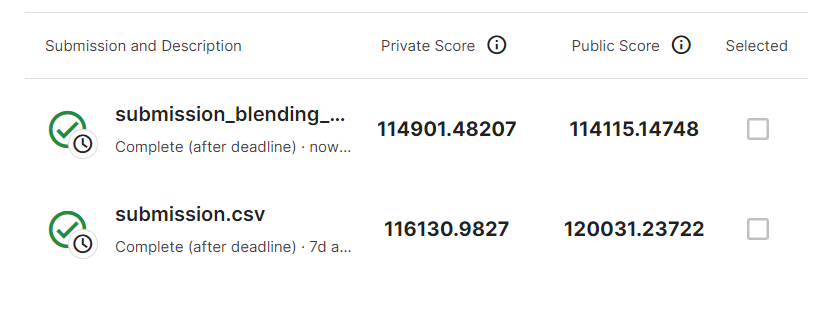

## 5. 회고

1. 프로젝트를 진행하며 가장 고민이 되었던 부분은 train 데이터와 test 데이터를 합치고 분석하는 것, 분할하는 것, 학습시키는 것에 대한 순서였다. baseline에서는 둘을 합친 후 분석하여 로그변환 한 뒤 다시 나누어 주었다.나는 합치지 않고 각자 학습시켰는데 그런 차이가 점수를 더 내리지 못하는 이유였나 싶고, 둘 다 시도해 볼걸하는 아쉬움이 남는다.
2. 그래프의 치우침에 대한 설명이 생각과 다른 부분이 있어서 헷갈렸다. 내가 생각하기에 치우친 데이터와 baseline에서의 치우친 데이터가 대부분 같긴 했지만 다른 것도 있었다.어떤 게 치우친 것인지 정확하게 파악하지 못하는 것 같아서 답답함이 있었는데 계속 데이터를 쳐다보다보니 구분할 수 있게 되어 좋았다.
3. 전에 그냥 데이터를 각각 확인하는 것이 아닌 함수를 만들어 사용하는 것에 대해 생각이 나서 그에 대한 아쉬움을 이야기한 적이 있는데 그 뒤에도 새 내용에 대해 학습하며 프로젝트를 진행하기 바빠 함수를 만들어 사용하는 것은 시도하지 못했는데 이번 프로젝트에서는 함수를 정의하여 사용해 볼 수 있어 좋았다. 함수를 사용하는 게 가독성도 더 좋고 간단하고 편하게 사용할 수 있는 것 같다. 앞으로는 함수 사용이 습관화 됐으면 좋겠다.

## (1) 시도한 것 & 고민했던 점
- 데이터톤을 진행할 때 다른 조에서 train 데이터와 test 데이터를 합쳐서 학습을 시켰다고 했다는 것이 기억나서 적용해보려 했는데 y 데이터가 train셋에만 있어서 어떻게 학습을 진행해야 할 지 고민이 됐다. 시간이 모자라서 답을 찾진 못했는데 다음 예측 모델을 구현할 때는 꼭 다시 시도해보고싶다.

## (2) 아쉬운 점
- 11000점 밑으로 점수를 내리지 못한게 너무 아쉽다. features engineering할 때만 해도 무조건 할 수 있을거라 생각했는데 후에 하이퍼파라미터 튜닝에 시간을 너무 적게 쓴 것 같아서 아쉽다. 


## 6. Reference

- os.path (https://docs.python.org/3/library/os.path.html#os.path.join)
- 로그변환, log1p (https://suppppppp.github.io/posts/Why-Series-MDM-1/)
- apply, lambda (https://koreadatascientist.tistory.com/115) (https://data-newbie.tistory.com/207)
- msno.matrix (https://jaaamj.tistory.com/109)
- np.sqrt (https://cosmosproject.tistory.com/442)
- 마크다운 색 바꾸기(https://geniewishescometrue.tistory.com/entry/%EB%A7%88%ED%81%AC%EB%8B%A4%EC%9A%B4-%EA%B4%80%EB%A0%A8-%ED%8C%81-%EA%B8%80-%EC%83%89%EC%83%81-%ED%98%95%EA%B4%91%ED%8E%9C)
- corr() (https://wikidocs.net/157461)
- 앙상블(블렌딩) (https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.),
(https://jamm-notnull.tistory.com/16)
- 그래프(https://hellobrocolli.tistory.com/23?category=1100137)
- le6 (https://stackoverflow.com/questions/55754938/what-does-1e-mean)
- R2 결정계수 (https://ltlkodae.tistory.com/19)
- 앙상블로 score올리기 (https://jamm-notnull.tistory.com/16)
- PolynomialFreature ()
- GBoost 하이퍼파라미터 (https://assaeunji.github.io/machine%20learning/2020-09-05-gbm/)